In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


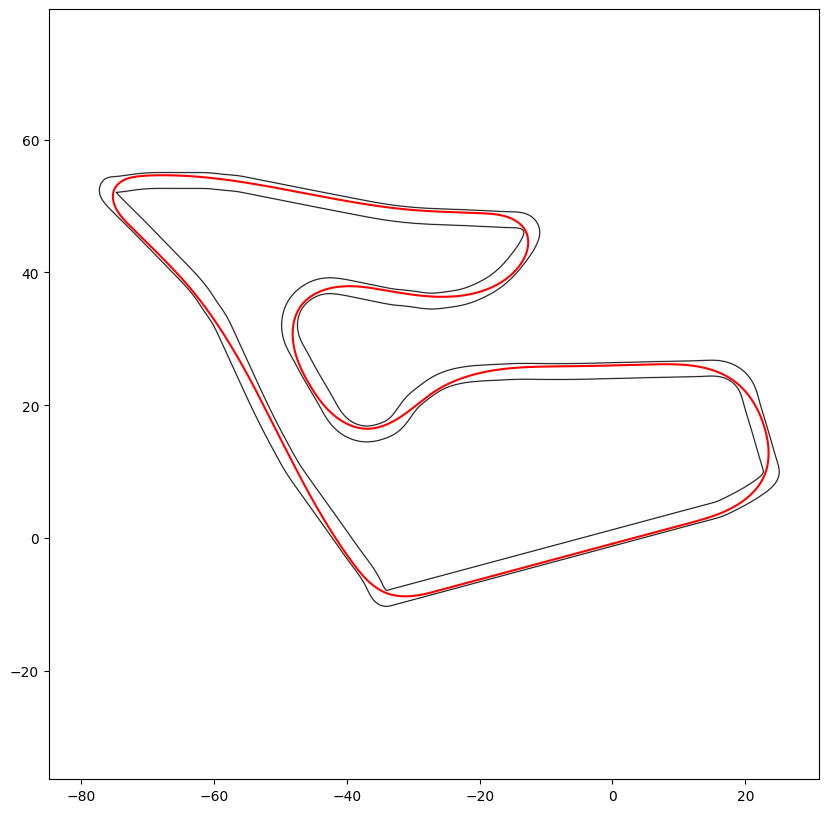

In [16]:
from ese200.racetrack import load_track, plot_track
track = load_track("../track/Spielberg")
plot_track(track)